In [44]:
import pandas as pd
import datetime 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os 
import itertools
from datetime import datetime

In [46]:
from plot_functions import plot_results_by_month

In [48]:
# Save current directory
current_directory = os.getcwd()

# Set print options to suppress scientific notation and show 3 decimal places
np.set_printoptions(suppress=True, precision=5)
pd.options.display.float_format = '{:.5f}'.format

# Suppress all warnings globally
import warnings
warnings.filterwarnings("ignore")

# Benchmark Models

When developing predictive models, it is essential to evaluate their performance against benchmark models. A **benchmark model** provides a standard for comparison, helping assess whether the advanced model offers meaningful improvements and hence justify the added computational or implementation complexity.

In this context, two benchmarks were chosen: 

1. **SARIMA** – a statistical model widely used for time series forecasting.
2. **Persistence Forecast Model** – a simple heuristic model that leverages historical values for predictions.

#### SARIMA 

SARIMA stands for **Seasonal AutoRegressive Integrated Moving Average**. It extends the ARIMA model by adding components to handle seasonality. 
SARIMA models can incorporate **exogenous variables**, such as temperature, to enhance forecasting accuracy. These variables provide additional context that helps capture dependencies between the target variable (e.g., power consumption) and external factors. The inputs to a SARIMA model with exogenous variables include:

1. **Endogenous variable**: The target variable (e.g., power consumption).
2. **Exogenous variables**: Additional explanatory variables (e.g., temperature, wind speed) provided as a time-aligned feature matrix.

SARIMA predicts future values based on the observed patterns in past data, using a combination of autoregression, differencing, and moving averages for both non-seasonal and seasonal components. It is defined by the following parameters:

- **Non-seasonal components**: (p, d, q):
  - **p**: Number of autoregressive (AR) terms.
  - **d**: Differencing order to achieve stationarity.
  - **q**: Number of moving average (MA) terms.
  
- **Seasonal components**: (P, D, Q, m):
  - **P**: Seasonal autoregressive terms.
  - **D**: Seasonal differencing order.
  - **Q**: Seasonal moving average terms.
  - **m**: Seasonal period (e.g., m = 24 for hourly data with a daily seasonality).

By combining seasonal patterns, trends, and exogenous inputs, SARIMA provides a flexible and interpretable framework for time series forecasting.

#### Persistence Forecast Model

The **Persistence Forecast Model** assumes that future values replicate past observations. Specifically:

- For a forecast horizon of 24 hours, the model predicts the power consumption for the next 24 hours as equal to the observed values from the last 24 hours.

This model is appealing for the reasons:

1. **Simplicity**: It requires no computational resources or training.
2. **Effectiveness in Stable Patterns**: For time series with high temporal stability or predictable cycles, persistence often yields reasonable predictions.
3. **Comparison Baseline**: It sets a low bar for more sophisticated models to outperform, helping to ensure that the chosen model adds value.

### Load pre-processed data

In [ ]:
# Load data

# train data
file_path = os.path.join(current_directory, 'data_augmented/train.csv')
train = pd.read_csv(file_path)
train.set_index("timestamp", inplace=True)
train.index = pd.to_datetime(train.index) # Set frequency explicitly
train = train.asfreq('H')  # 'H' for hourly frequency

# test data
file_path = os.path.join(current_directory, 'data_augmented/test.csv')
test = pd.read_csv(file_path)
test.set_index("timestamp", inplace=True)
test.index = pd.to_datetime(test.index) # Set frequency explicitly
test = test.asfreq('H')  # 'H' for hourly frequency

# timestamps
timestamps_train = train.index
timestamps_test = test.index

## SARIMA

In [55]:
# Determine the target and exogenous variables
target_col = ['power_consumption']
exog_cols = [] # Choose between: [], ['temp'], [col for col in train.columns if col not in target_col]

train_data = train[target_col].values.flatten()
train_exog = train[exog_cols].values.flatten()
test_data = test[target_col].values.flatten()
test_exog = test[exog_cols].values.flatten()

#### AutoARIMA for SARIMA Parameter Selection

AutoARIMA automates the process of finding the optimal SARIMA parameters (p, d, q) and (P, D, Q, m), crucial for accurate forecasting. It minimizes metrics like AIC or BIC using stepwise search, which balances model accuracy and computational efficiency.

The provided function `determine_best_parameters` uses AutoARIMA to:
1. Automatically assess the data's stationarity and differencing needs.
2. Search the parameter space for seasonal and non-seasonal ARIMA terms.
3. Return the best-fit parameters for the SARIMA model.

This approach streamlines workflow, ensures better forecasting accuracy, and handles exogenous variables (e.g., temperature) seamlessly, making it ideal for modeling power consumption.

In [10]:
from pmdarima import auto_arima

# Parameters selection
parameters_selection = 0    # 0 -> manual parameter selection 
                            # 1 -> autoARIMA

if parameters_selection == 0:
    # Manual 
    order = (1,1,0)
    seasonal_order = (1,1,0,24) # (1,0,0,24)
elif parameters_selection == 1:
    # Auto-ARIMA for Parameter Selection
    def determine_best_parameters(train, exog_train, seasonal_period = 24):
        """
        Automatically determine the best SARIMAX parameters using auto_arima.
        """
        
        train = train.astype('float32') 
        
        # Handle case where no exogenous variables are provided
        if exog_train.size == 0:  # Check if the exog_train array is empty
            exog_train = None  # Set exog_train to None if empty
        else:
            exog_train = exog_train.astype('float32')

        seasonal_period = 24
        model = auto_arima(
            train,  # Target variable
            exogenous=exog_train,  # Exogenous variables
            seasonal=True,  # Enable seasonal ARIMA
            m = seasonal_period,  # Number of time steps in a seasonal period
            start_p=0, max_p=1,  # Restrict AR terms
            d = None,  # Automatically determine differencing order
            start_q=0, max_q=1, # Restrict MA terms
            start_P=0, max_P=1, # Restrict seasonal AR terms
            D = None,  # Automatically determine seasonal differencing order
            start_Q=0, max_Q=1, # Restrict seasonal MA terms
            stepwise=True,  # Use stepwise search to reduce computational cost
            suppress_warnings=True,  # Suppress warnings during execution
            max_order=10,  # Limit the sum of p + q + P + Q
            trace=True  # Enable tracing to monitor progress
        )
        print(f"Best order: {model.order}")
        print(f"Best seasonal order: {model.seasonal_order}")
        return model.order, model.seasonal_order
    
    # Determine best parameters
    order, seasonal_order = determine_best_parameters(
        train_data,
        exog_train=train_exog
    )

### Sliding Window Training and Forecasting with SARIMA

The code below implements a **sliding window approach** to iteratively train and forecast using the SARIMA model. It is designed to predict a rolling forecast horizon, such as the next 24 hours of power consumption, while updating the model as new data becomes available.

#### Key Steps

1. **Initial Model Training**:
   - The SARIMA model is trained on the **training set**, using both the target variable (`train_data`) and the exogenous variables (`train_exog`).
   - This step establishes the baseline model, capturing the historical patterns and relationships in the data.

2. **Rolling Forecasts**:
   - The test set is divided into intervals of 24 hours, corresponding to the **forecast horizon**.
   - For each interval:
     - The model forecasts the next 24 hours using the exogenous variables (`test_exog`) for that period.
     - Predictions and corresponding actual values (`test_data`) are stored for evaluation.

3. **Model Updates**:
   - After each forecast, the model is **refitted** with updated training data, combining the original training set with actuals from the test set up to the current point.
   - This step ensures the model incorporates the latest available information, improving adaptability to recent trends.

This approach is valuable for 
   - **Realism**: Simulates real-world forecasting scenarios where predictions are made sequentially as new data becomes available.
   - **Improved Adaptability**: Refitting the model with updated data allows it to respond to potential changes in patterns or relationships over time.
   - **Robust Evaluation**: Produces predictions across multiple intervals, testing the model's ability to generalize beyond static data.

This iterative process ensures the model remains relevant for real-world applications, such as day-ahead energy forecasting, where updated forecasts are crucial for operational planning and decision-making.

In [11]:
# Train and fit SARIMAX Model
from statsmodels.tsa.statespace.sarimax import SARIMAX

def train_sarimax(train, exog_train, order, seasonal_order):
    """
    Train a SARIMAX model with specified parameters.
    """
    # Handle case where no exogenous variables are provided
    if exog_train.size == 0:  # Check if the exog_train array is empty
        exog_train = None  # Set exog_train to None if empty
 
    model = SARIMAX(
        train,
        exog=exog_train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted_model = model.fit(disp=False)
    return fitted_model

In [12]:
forecast_horizon = 24

# Step 1: Fit the SARIMA model on the initial training set
# The model is trained using historical data and corresponding exogenous variables
fitted_model = train_sarimax(
                                train_data,
                                exog_train=train_exog,
                                order=order,
                                seasonal_order=seasonal_order
                                )

# Initialize empty lists to store predictions and actual values for evaluation
all_predictions = []
all_actuals = []

# Step 2: Perform rolling forecasts over the test set
for i in range(0, len(test_data) - forecast_horizon + 1, forecast_horizon):
    # Extract exogenous variables for the current forecast window
    forecast_exog = test_exog[i:i + forecast_horizon]
    # Generate forecasts for the next 24 hours using the fitted model
    forecast = fitted_model.forecast(steps=forecast_horizon, exog=forecast_exog)
    # Get the corresponding actual values for evaluation
    actual = test_data[i:i + forecast_horizon]

    # Store the predictions and actual values for this forecast window
    all_predictions.extend(forecast)
    all_actuals.extend(actual)

    # Step 3: Update the model for the next forecast window
    # Extend the training data with actuals from the current test interval
    updated_train_data = np.append(train_data, test_data[:i + forecast_horizon])
    # Extend the exogenous variables similarly
    updated_train_exog = np.append(train_exog, test_exog[:i + forecast_horizon])
    # Refit the model with the updated training data
    fitted_model = train_sarimax(
                                updated_train_data,
                                exog_train=updated_train_exog,
                                order=order,
                                seasonal_order=seasonal_order
                                )

# Convert predictions and actuals to numpy arrays for further analysis
all_predictions = np.array(all_predictions)
all_actuals = np.array(all_actuals)


In [13]:
predictions = pd.Series(data=all_predictions, index=timestamps_test.values)
actuals = pd.Series(data=all_actuals, index=timestamps_test.values)

In [14]:
file_path = os.path.join(current_directory, 'results/errors.csv')
errors = pd.read_csv(file_path, index_col=0)

### SARIMA Model evaluation 

### Metrics to Evaluate Prediction Accuracy

The evaluation of prediction accuracy is performed with multiple metrics, as each highlights different aspects of model performance. 

1. **Root Mean Squared Error (RMSE)**  
   $$
   \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n (\hat{y}_i - y_i)^2}
   $$
   - Sensitive to large errors (penalizes outliers).  
   - Captures the overall accuracy but is non-robust to extreme values.
     

2. **Mean Absolute Error (MAE)**  
   $$
   \text{MAE} = \frac{1}{n} \sum_{i=1}^n |\hat{y}_i - y_i|
   $$  
   - Treats all errors equally.  
   - Provides a robust measure of the average error magnitude.

  
3. **Maximum Error (ME)**  
   $$
   \text{ME} = \max(|\hat{y}_i - y_i|)
   $$  
   - Highlights the largest deviation, capturing extreme behavior.

  
4. **Mean Absolute Percentage Error (MAPE)**  
   $$
   \text{MAPE} = \frac{100}{n} \sum_{i=1}^n \left| \frac{\hat{y}_i - y_i}{y_i} \right|
   $$  
   - Expresses errors as a percentage, providing relative interpretability.  
   - Sensitive to small actual values.

These metrics together offer a holistic evaluation of a model, balancing overall accuracy, robustness, and sensitivity to extreme deviations.

In [ ]:
# Import metrics for predictions accuracy evaluation

# MSE
from sklearn.metrics import mean_squared_error

# RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
    
# MAE
from sklearn.metrics import mean_absolute_error

# MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) # * 100

# ME
from sklearn.metrics import max_error

In [15]:
# Evaluate predictions accuracy 
new_row = {'RMSE': root_mean_squared_error(actuals, predictions), 
                        'MAE': mean_absolute_error(actuals, predictions), 
                        'ME': max_error(actuals, predictions), 
                        'MAPE': mean_absolute_percentage_error(actuals, predictions)}

errors.loc['SARIMA'] = new_row

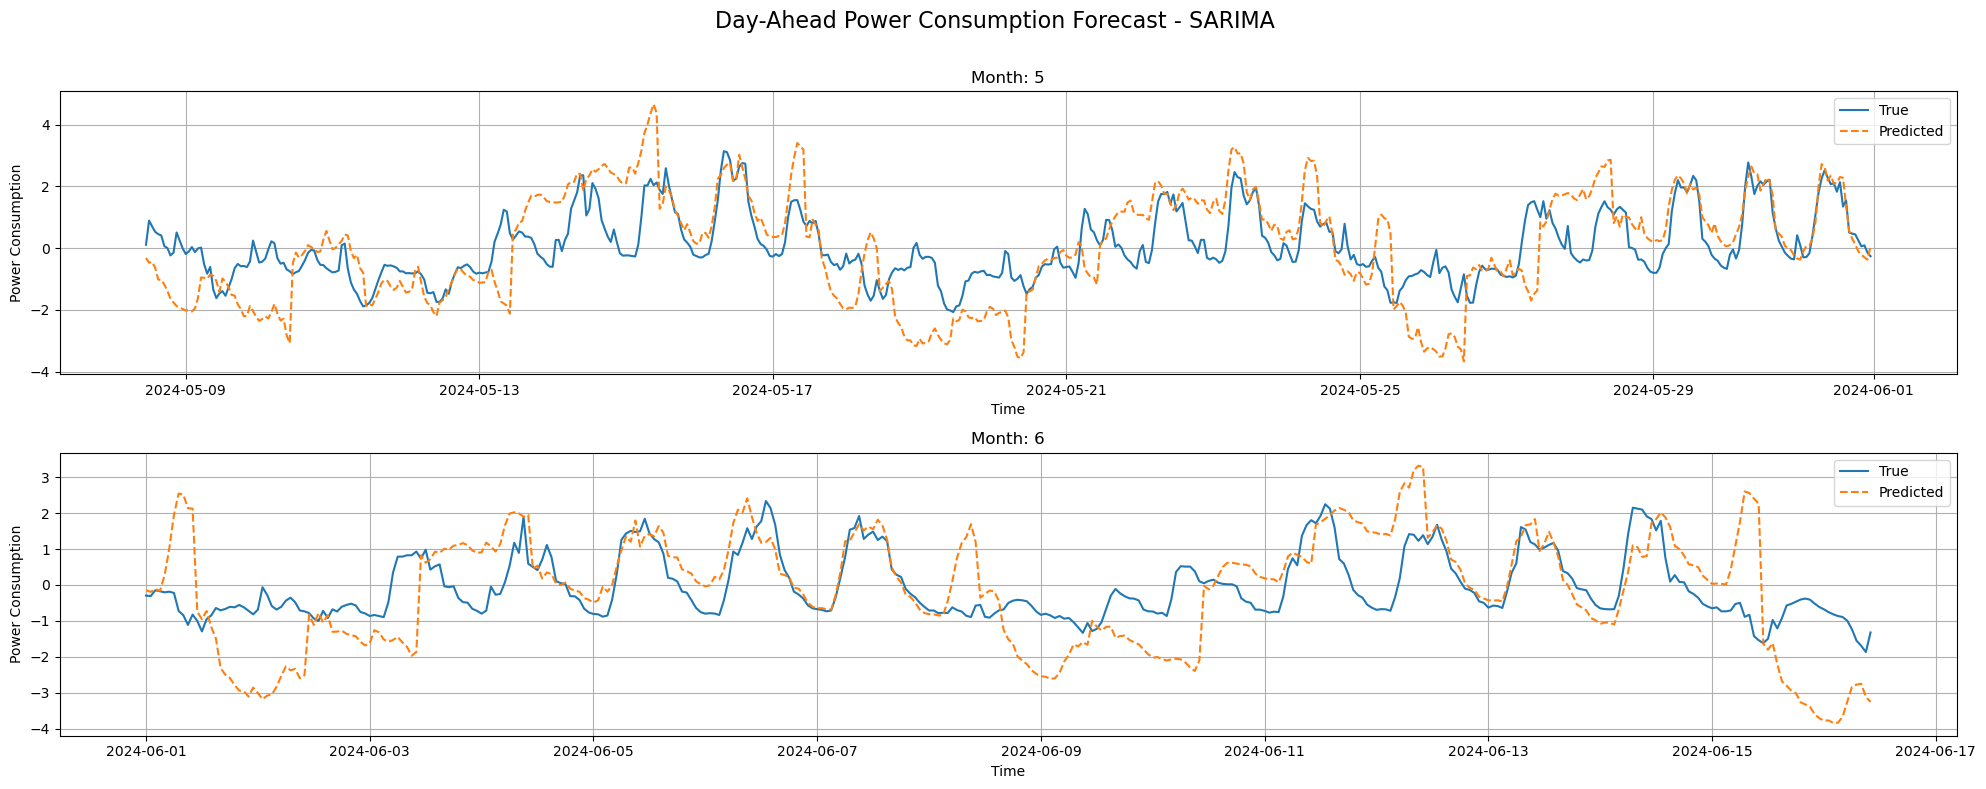

In [16]:
# Plot predicted vs true target variable
file_path = os.path.join(current_directory, 'results/SARIMA.png')
plot_results_by_month(predictions, actuals, "Day-Ahead Power Consumption Forecast - SARIMA", file_path)

## Persistence Forecast Model

In [18]:
# Step 1: Extend the test set with the last 24 hours of training data
augmented_test = pd.concat([train[-24:], test], axis=0)

# Step 2: Shift the target column by 24 hours
augmented_test[target_col] = augmented_test[target_col].shift(24)

# Step 3: Remove the first 24 rows
augmented_test = augmented_test[24:]

# Step 4: Extract predictions
predictions = augmented_test[target_col]

### Persistence Forecast Model evaluation

In [19]:
# Evaluate predictions accuracy
new_row = {'RMSE': root_mean_squared_error(actuals, predictions), 
                        'MAE': mean_absolute_error(actuals, predictions), 
                        'ME': max_error(actuals, predictions), 
                        'MAPE': mean_absolute_percentage_error(actuals, predictions)}

errors.loc['Persistence Forecast'] = new_row
file_path = os.path.join(current_directory, 'results/errors.csv')
errors.to_csv(file_path)
errors

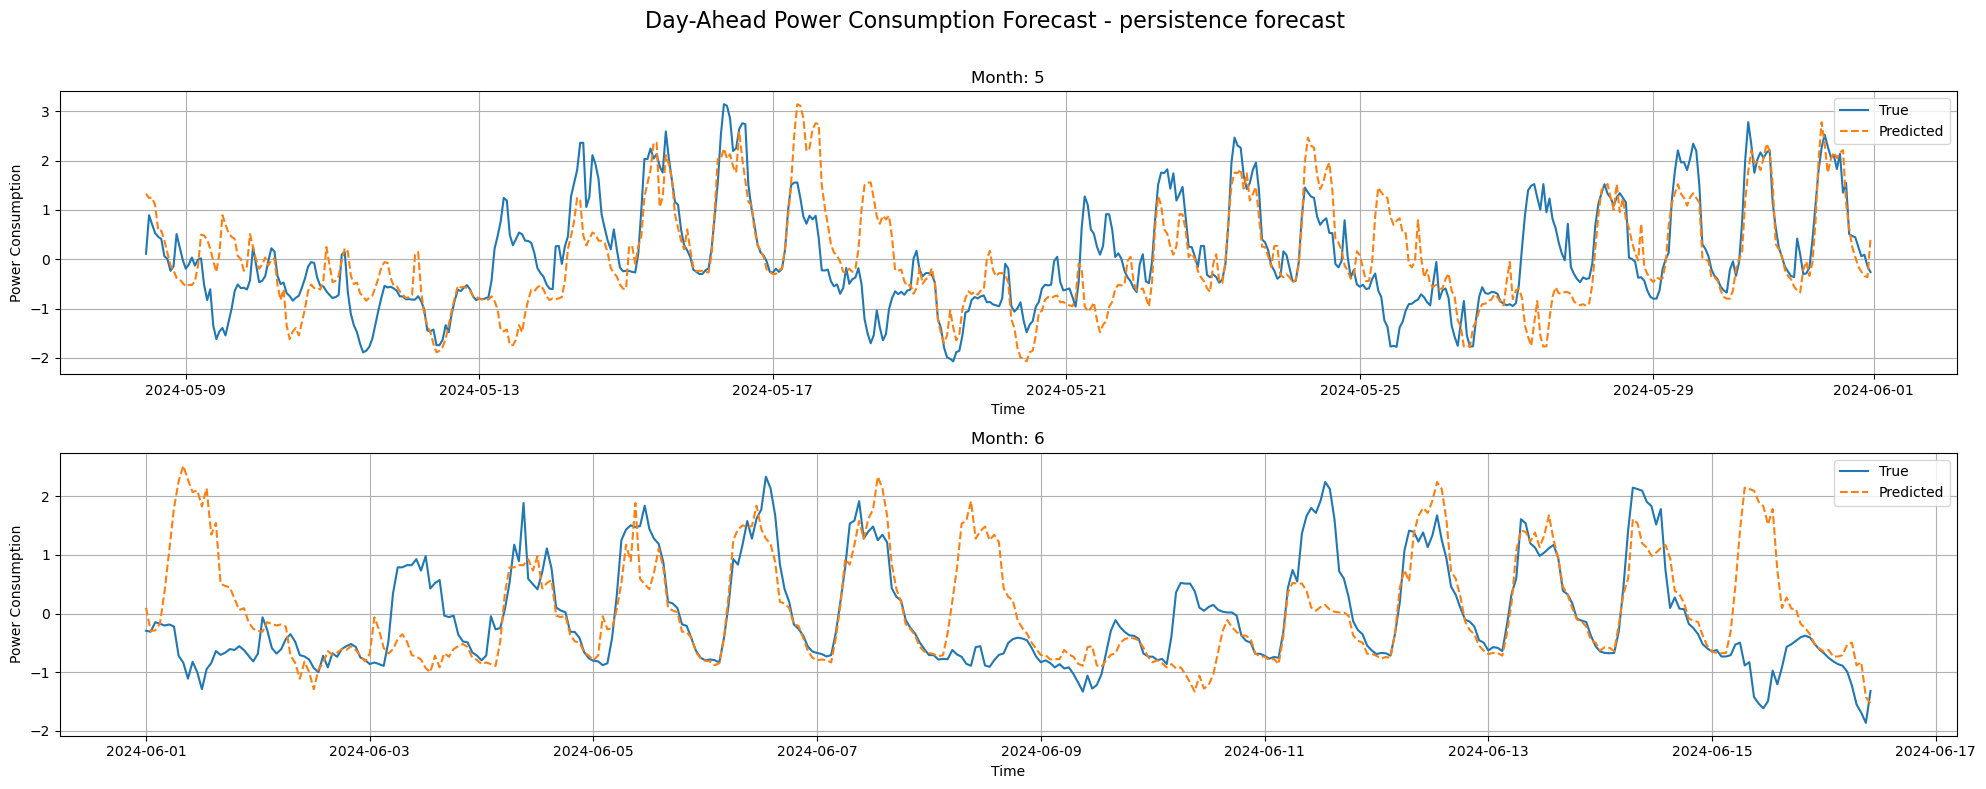

In [22]:
# Plot predicted vs true target variable
file_path = os.path.join(current_directory, 'results/persistence_forecast.png')
plot_results_by_month(predictions, actuals, "Day-Ahead Power Consumption Forecast - persistence forecast", file_path)